# **1. Data Loading and Cleaning:**

> Load the dataset from a CSV file named obesity_data.csv.

> Handle missing values, outliers, and encode categorical variables.



In [1]:
import pandas as pd

# Load the dataset
obesity_data = pd.read_csv("obesity_data.csv")
obesity_data

,Age,Gender,Height,Weight,BMI,PhysicalActivityLevel,ObesityCategory
0,56,Male,173.575262,71.982051,23.891783,4,Normal weight
1,69,Male,164.127306,89.959256,33.395209,2,Obese
2,46,Female,168.072202,72.930629,25.817737,4,Overweight
3,32,Male,168.459633,84.886912,29.912247,3,Overweight
4,60,Male,183.568568,69.038945,20.487903,3,Normal weight
...,...,...,...,...,...,...,...
995,18,Male,155.588674,64.103182,26.480345,4,Overweight
996,35,Female,165.076490,97.639771,35.830783,1,Obese
997,49,Female,156.570956,78.804284,32.146036,1,Obese
998,64,Male,164.192222,57.978115,21.505965,4,Normal weight


In [2]:
from scipy.stats import zscore

# Checking for null values
null_values = obesity_data.isnull().sum()

# Display columns with null values
print("Columns with null values:")
print(null_values[null_values > 0])

# Droping rows with null values
obesity_data.dropna(inplace=True)

# Detect outliers in the "Weight" column using z-score
z_scores = zscore(obesity_data["Weight"])
outliers_detected = (z_scores > 3) | (z_scores < -3)

# Remove outliers if any
obesity_data = obesity_data[~outliers_detected]

# Encoding categorical value using One-hot encoding for "Gender"
obesity_data = pd.get_dummies(obesity_data, columns=["Gender"])

obesity_data

Columns with null values:
Series([], dtype: int64)


,Age,Height,Weight,BMI,PhysicalActivityLevel,ObesityCategory,Gender_Female,Gender_Male
0,56,173.575262,71.982051,23.891783,4,Normal weight,False,True
1,69,164.127306,89.959256,33.395209,2,Obese,False,True
2,46,168.072202,72.930629,25.817737,4,Overweight,True,False
3,32,168.459633,84.886912,29.912247,3,Overweight,False,True
4,60,183.568568,69.038945,20.487903,3,Normal weight,False,True
...,...,...,...,...,...,...,...,...
995,18,155.588674,64.103182,26.480345,4,Overweight,False,True
996,35,165.076490,97.639771,35.830783,1,Obese,True,False
997,49,156.570956,78.804284,32.146036,1,Obese,True,False
998,64,164.192222,57.978115,21.505965,4,Normal weight,False,True


# **2. Feature Selection and Preprocessing:**

> Select the desired features (e.g., BMI, PhysicalActivityLevel, Gender_Female, Gender_Male).

> Standardize the selected features using StandardScaler.

In [3]:
from sklearn.preprocessing import StandardScaler

# Feature Selection: features based on the dataset
selected_features = obesity_data[["BMI", "PhysicalActivityLevel", "Gender_Female", "Gender_Male"]]

# Standardize features using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)


# **3. Clustering Analysis (K-means):**

> Apply K-means clustering to identify clusters based on the selected features.

> Visualize cluster characteristics (e.g., age distribution, gender composition).

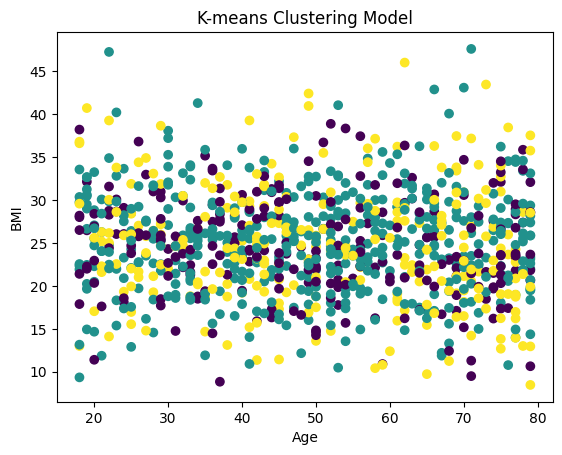

In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Fit K-means model
kmeans_model = KMeans(n_clusters=3, random_state=42)
obesity_data["Cluster"] = kmeans_model.fit_predict(scaled_features)

# Visualize cluster characteristics (e.g., age distribution)
plt.scatter(obesity_data["Age"], obesity_data["BMI"], c=obesity_data["Cluster"], cmap="viridis")
plt.title("K-means Clustering Model")
plt.xlabel("Age")
plt.ylabel("BMI")
plt.show()


# **4. Feature Selection using ANOVA F-test:**

> Use ANOVA F-test to select top k features relevant to ObesityCategory.

> Transform feature set to contain only selected features.

In [5]:
from sklearn.feature_selection import SelectKBest, f_classif

# Assuming ObesityCategory is the target variable
X = scaled_features
y = obesity_data["ObesityCategory"]

# Select top k features using ANOVA F-test
k = 2
selector = SelectKBest(f_classif, k=k)
selected_X = selector.fit_transform(X, y)


# **5. Splitting Data and SVM Classification:**


> Split dataset into training and testing sets.
Initialize an SVM classifier with RBF kernel.


> Fit SVM model on training data and predict on test set.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Spliting the data to train and test
X_train, X_test, y_train, y_test = train_test_split(selected_X, y, test_size=0.2, random_state=42)

# Initialize SVM classifier
svm_classifier_model = SVC(kernel="rbf", C=1.0, gamma="scale")

# Fit SVM model
svm_classifier_model.fit(X_train, y_train)

# Predict on test set
y_pred = svm_classifier_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.97


# **6. Weight Variation Analysis:**

> Analyze weight distribution among different age groups.

> Explore age-weight relationship through visualization.

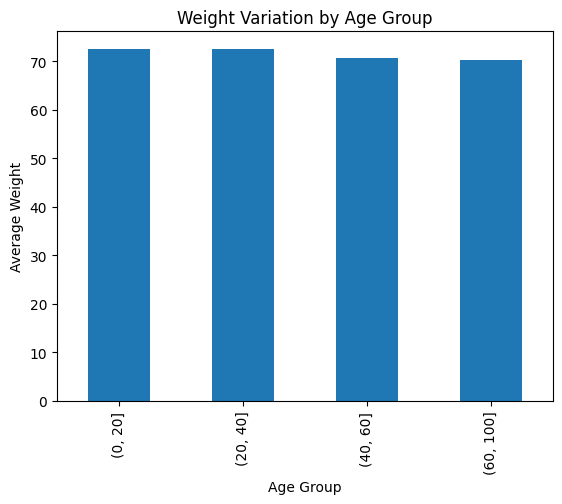

In [7]:
age_groups = obesity_data.groupby(pd.cut(obesity_data["Age"], bins=[0, 20, 40, 60, 100]))
average_weight_by_age = age_groups["Weight"].mean()

# Visualize average weight by age group
average_weight_by_age.plot(kind="bar", xlabel="Age Group", ylabel="Average Weight", title="Weight Variation by Age Group")
plt.show()


# **7. Group Analysis:**

> Group data by age group and compute average weight within each group.

> Determine predominant obesity category within each age group.

In [8]:
grouped_data = obesity_data.groupby("Age").agg({"Weight": "mean", "ObesityCategory": lambda x: x.value_counts().idxmax()})
grouped_data.rename(columns={"Weight": "Average Weight", "ObesityCategory": "Predominant Category"}, inplace=True)
print(grouped_data)


     Average Weight Predominant Category
Age                                     
18        73.193827                Obese
19        74.001149                Obese
20        69.900723           Overweight
21        64.668888           Overweight
22        76.495007                Obese
..              ...                  ...
75        70.803326        Normal weight
76        71.117418        Normal weight
77        69.048810        Normal weight
78        74.334152           Overweight
79        68.580012        Normal weight

[62 rows x 2 columns]


# **8. Lifestyle and Behavioral Analysis:**

> Diet and Exercise Habits:
Group individuals based on their PhysicalActivityLevel (Normal Weight, Obese, Overweight, Underweight) and analyze the distribution of obesity categories within each group.

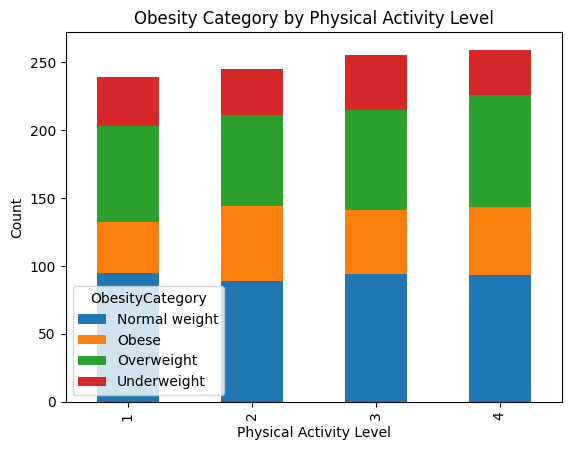

In [9]:
# Group by activity level and count obesity categories
act_lvl_obs_count = obesity_data.groupby('PhysicalActivityLevel')['ObesityCategory'].value_counts().unstack()

import matplotlib.pyplot as plt1

act_lvl_obs_count.plot(kind='bar', stacked=True)
plt1.title('Obesity Category by Physical Activity Level')
plt1.xlabel('Physical Activity Level')
plt1.ylabel('Count')
plt1.show()

# **9. Risk Factor Analysis:**



> Identifying High-Risk Groups: Logistic Regression


> Accuracy: Overall proportion of correctly classified instances.

> Precision: Measures how many of the predicted obese cases were truly obese.

> Recall: Measures how many of the actual obese cases were correctly predicted.

> Confusion Matrix: A table that visualizes the distribution of correct and incorrect predictions for each category (Obese and Not Obese).



Accuracy: 0.975
Precision: 0.9753846153846155
Recall: 0.975
Confusion Matrix:
 [[63  0  1  0]
 [ 0 33  2  0]
 [ 2  0 62  0]
 [ 0  0  0 37]]


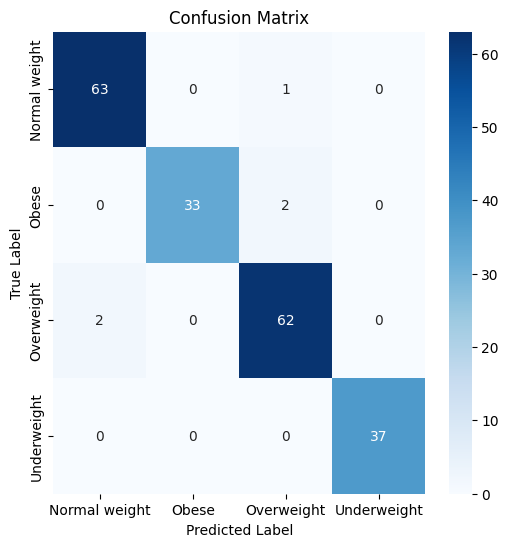

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Feature matrix (X) and target variable (y)
X = obesity_data[['Age', 'Height', 'Weight', 'BMI', 'PhysicalActivityLevel', 'Gender_Female']]
y = obesity_data['ObesityCategory']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the logistic regression model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train_scaled, y_train)

# Prediction
y_pred = log_reg_model.predict(X_test_scaled)

# Model accuracy
accuracy_val = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_val)

# Precision
precision_val = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision_val)

# Recall
recall_scr = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall_scr)

# Confusion Matrix
confusion_matrix_result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_matrix_result)

# Get unique class labels from target variable
class_labels = y.unique()

# Generate confusion matrix heatmap with labels
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_result, annot=True,
            fmt='d',  # format to display integer values
            cmap='Blues',  # colormap for the heatmap
            xticklabels=class_labels,  # set x-axis labels
            yticklabels=class_labels)  # set y-axis labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()